# Airplane Detection and classification

In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab import drive

In [ ]:
train_images=[]
train_labels=[]
path="/content/drive/MyDrive/Colab Notebooks/ML_Project/Images"
annot="/content/drive/MyDrive/Colab Notebooks/ML_Project/annotations"

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


airplane_001.csv
airplane_001.jpg
               3
0  173 15 232 70
1  49 76 139 153
2   4 164 93 244
173 15
49 76
4 164


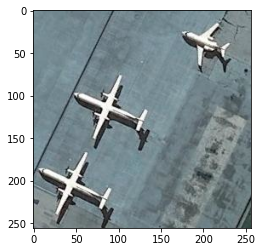

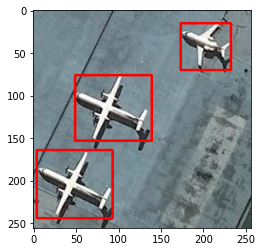

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        print(i)
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))  # read annotations file wrt image file
        print(df)
        plt.imshow(img)
        plt.savefig("real image.png")
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            print(x1,y1)
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)  # for bounding boxes
        plt.figure()
        plt.imshow(img)
        plt.savefig("img_box.png")
        break

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

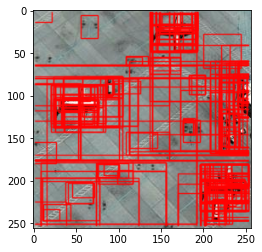

In [ ]:
img=cv2.imread(os.path.join(path,"airplane_407.jpg"))
# set base image
#plt.imshow(img)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects=ss.process()  # rects store all the rectangles coordinate (x1,y1),(x2,y2)
imout=img.copy()
count=0
for e,rect in enumerate(rects):
    x,y,w,h=rect
    cv2.rectangle(imout,(x,y),(x+w,y+h),(255,2,2),1,cv2.LINE_AA)
plt.imshow(imout)
plt.savefig("all_region.png")


INTERSECTION over UNION

iou=area of intersection of two boxes/ area of union

In [ ]:
def get_IOU(block1,block2):
    assert block1['x1']<block1['x2']
    assert block1['y1']<block1['y2']
    assert block2['x1']<block2['x2']
    assert block2['y1']<block2['y2']

    x_left=max(block1['x1'],block2['x1'])
    y_top=max(block1['y1'],block2['y1'])
    x_right=min(block1['x2'],block2['x2'])
    y_bottom=min(block1['y2'],block2['y2'])
    
    if x_right<x_left or y_bottom<y_top:
        return 0.0
    # intersection area
    intersection_area=(x_right-x_left)*(y_bottom-y_top)
    # area of both blocks
    area_b1=(block1['x2']-block1['x1'])*(block1['y2']-block1['y1'])
    area_b2=(block2['x2']-block2['x1'])*(block2['y2']-block2['y1'])

    iou=intersection_area/float(area_b1+area_b2-intersection_area)

    return iou
    


In [ ]:
print(get_IOU({"x1":20,"x2":30,"y1":20,"y2":30},{"x1":15,"x2":25,"y1":15,"y2":25}))

0.14285714285714285


for preprocess the image and make grid around it if iou >0.7 make rectangle

In [ ]:
counting=0
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane") and counting<150:
            counting+=1
            filename=i.split(".")[0]+".jpg"
            print(e,filename)
            image=cv2.imread(os.path.join(path,filename))
            data=pd.read_csv(os.path.join(annot,i))
            #print(data)
            values=[]
            for row in data.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                values.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            
            # for griding the image region
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ss_results=ss.process() # store all rectangles coordinates
            #print(ss_results)
            imout=image.copy() # copy real image
            

            true_counter=0
            false_counter=0
            flag=0
            fflag=0
            bflag=0
            for e,result in enumerate(ss_results):
                if e<2000 and flag==0:
                    #print(result)
                    for val in values:
                        x,y,w,h=result
                        # get iou value
                        iou=get_IOU(val,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        # take image that has aeroplane
                        if true_counter<30:
                            if iou>0.70:
                                t_img=imout[y:y+h,x:x+w]
                                resized=cv2.resize(t_img,(224,224),interpolation=cv2.INTER_AREA) 
                                train_images.append(resized)
                                train_labels.append(1)  # denote 1 as there is aeroplane in there use for classification
                                true_counter+=1
                        else:
                            fflag=1
                        # take image that has no aeroplane
                        if false_counter<30:
                            if iou<0.3:
                                t_img=imout[y:y+h,x:x+w]
                                resized=cv2.resize(t_img,(224,224),interpolation=cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)  # denote 0 as there is no aeroplane in there use for classification
                                false_counter+=1
                        else:
                            bflag=1
                    if fflag==1 and bflag==1:
                        print("inside")
                        flag=1
                


    except Exception as e:
        print(e)
        print("error in "+filename)
        continue
    

0 airplane_001.jpg
inside
1 airplane_228.jpg
2 airplane_168.jpg
3 airplane_147.jpg
4 airplane_301.jpg
inside
5 airplane_309.jpg
6 airplane_133.jpg
7 airplane_077.jpg
8 airplane_110.jpg
9 airplane_131.jpg
10 airplane_120.jpg
inside
11 airplane_128.jpg
12 airplane_313.jpg
13 airplane_303.jpg
14 airplane_049.jpg
15 airplane_272.jpg
18 airplane_140.jpg
19 airplane_097.jpg
inside
20 airplane_137.jpg
inside
21 airplane_115.jpg
22 airplane_058.jpg
23 airplane_158.jpg
24 airplane_148.jpg
28 airplane_161.jpg
29 airplane_139.jpg
30 airplane_085.jpg
inside
31 airplane_165.jpg
32 airplane_078.jpg
33 airplane_150.jpg
34 airplane_224.jpg
35 airplane_007.jpg
inside
36 airplane_045.jpg
inside
37 airplane_028.jpg
38 airplane_205.jpg
39 airplane_296.jpg
40 airplane_308.jpg
41 airplane_047.jpg
42 airplane_255.jpg
43 airplane_021.jpg
44 airplane_037.jpg
45 airplane_242.jpg
46 airplane_079.jpg
47 airplane_197.jpg
48 airplane_008.jpg
49 airplane_055.jpg
50 airplane_300.jpg
51 airplane_102.jpg
52 airplane_10

In [ ]:
x_new=np.array(train_images)
x_new.shape

(6503, 224, 224, 3)

In [ ]:
x_labels=np.array(train_labels)
x_labels.shape

(6503,)

1

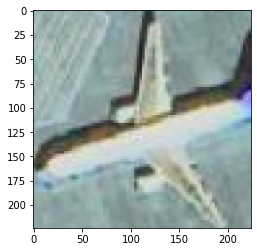

In [ ]:
plt.imshow(x_new[100])
x_labels[100]

0

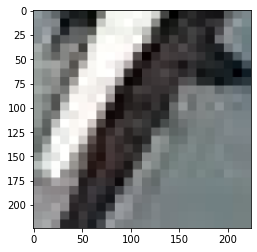

In [ ]:
plt.imshow(x_new[10])
x_labels[10]

In [ ]:
import keras 
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
# default input size of image (224,224)
vgg_model=VGG16(
    weights='imagenet',
    include_top=True
)

553476096/553467096 [==============================] - 5s 0us/step


In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# for freeze the layers that can't be change b/w training the model or fit
# layer.trainable=False

for layer in (vgg_model.layers)[:15]:
  print(layer)
  layer.trainable=False


In [ ]:
sec_last=vgg_model.layers[-2].output 
sec_last

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc2')>

In [ ]:
predictions=Dense(2,activation="softmax")(sec_last) # making last layer of two class 

In [ ]:
Final_model=Model(inputs=vgg_model.input,outputs=predictions)

In [ ]:
Final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Adam optimization is a stochastic gradient descent method 
#that is based on adaptive estimation of first-order and second-order moments.

# During the back propagation we pass the desired output then the error coming from desired output with output of layer(l) 
# we have to minimize the error, minimum squared error so we use steepest descent algorithm
# Here we use Adam with learning rate=0.0001

optimizer=optimizers.adam_v2.Adam(learning_rate=0.0001)

In [ ]:
'''
        losses - Computes the crossentropy loss between the labels and predictions
                 categorical_crossentropy used when 2 or more classes
                 
                 for label is integer used SparseCategoricalCrossentropy loss
        metrics - for judging the performance the model
                
'''

Final_model.compile(optimizer=optimizer,loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [ ]:
Final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:

lenc=MyLabelBinarizer()
y=lenc.fit_transform(x_labels)

In [ ]:
y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(x_new,y,test_size=0.10)  # for spliting the train test data

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(5852, 224, 224, 3) (651, 224, 224, 3) (5852, 2) (651, 2)


ImageDataGenerator class allows you to randomly rotate images through any degree between 0 and 360 by providing an integer value in the rotation_range argument.

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)

tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping    
# A callback is an object that can perform actions at various stages of training 
# at the start or end of an epoch, before or after a single batch

In [ ]:
# save model of best performance and for monitoring the model losses as val_loss
checkpoint = ModelCheckpoint("rcnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# monitor - quantity(val_loss) to be monitored
# patience: Number of epochs with no improvement after which training will be stopped
# verbose =1 show messages
# min_delta : minimum change in the monitored quantity to qualify as an improvement, i.e. 
#             an absolute change of less than min_delta, will count as no improvement.

early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = Final_model.fit(
    traindata, steps_per_epoch= 10, epochs= 20, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early]
    )

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 1.2036 - accuracy: 0.7312
Epoch 1: val_loss improved from inf to 0.33958, saving model to rcnn_vgg16_1.h5
10/10 [==============================] - 29s 2s/step - loss: 1.2036 - accuracy: 0.7312 - val_loss: 0.3396 - val_accuracy: 0.8438
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.8625
Epoch 2: val_loss did not improve from 0.33958
10/10 [==============================] - 6s 606ms/step - loss: 0.2960 - accuracy: 0.8625 - val_loss: 0.4219 - val_accuracy: 0.9062
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.8656
Epoch 3: val_loss improved from 0.33958 to 0.18952, saving model to rcnn_vgg16_1.h5
10/10 [==============================] - 13s 1s/step - loss: 0.3302 - accuracy: 0.8656 - val_loss: 0.1895 - val_accuracy: 0.9375
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9125
Epoch 4: val_loss improv

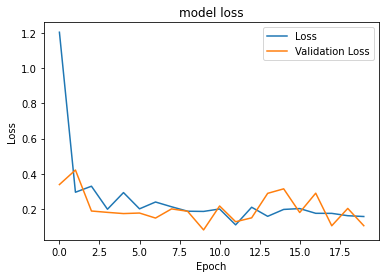

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig("chart loss.png")

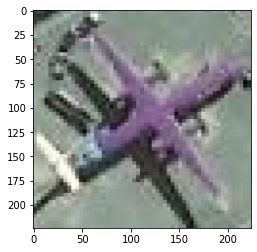

In [ ]:
im=X_test[100]
plt.imshow(im)


In [ ]:
print(y_test[100])

[1 0]


[[0.83385104 0.16614898]]
plane


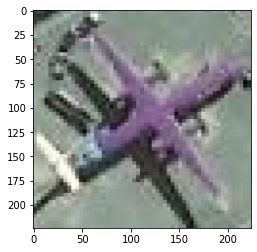

In [ ]:
img=X_test[100]
plt.imshow(img)
img = np.expand_dims(img, axis=0)  

out= Final_model.predict(img)
print(out)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

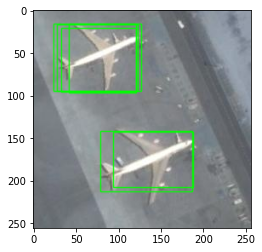

In [ ]:
z=0
max=0.65
for e,i in enumerate(os.listdir(path)):
    if i.startswith("airplane_012"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()

        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                
                img = np.expand_dims(resized, axis=0)
                out= Final_model.predict(img)
                #max=max(out[0][0],max)
                if out[0][0] > 0.7:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)